In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata as an
import scipy
from scipy.sparse import csr_matrix
import sklearn
import gget
import scanpy.external as sce
import math

sc.settings.verbosity = 3  

import utils as ut
import plotting as plt2

In [2]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/scanpy/merged_scfib.h5ad"
adata = sc.read_h5ad(fpath)
adata.obs['UMAP 1'] = adata.obsm['X_umap'][:, 0]
adata.obs['UMAP 2'] = adata.obsm['X_umap'][:, 1]
adata.obs['cluster_name'] = adata.obs['new_cluster'].apply(lambda x : f"F{int(x) + 1}")
adata.obs['to_drop'] = np.where(adata.obs['cluster_name'].isin(['F8', 'F9']), True, False)
sc.logging.print_memory_usage()
adata

Memory usage: current 8.09 GB, difference +8.09 GB


AnnData object with n_obs × n_vars = 16130 × 13579
    obs: 'cluster_str', 'dataset', 'pred_phase', 'leiden', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'new_cluster', 'UMAP 1', 'UMAP 2', 'cluster_name', 'to_drop'
    var: 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'cluster_str_colors', 'dataset_colors', 'hvg', 'log1p', 'neighbors', 'new_cluster', 'new_cluster_colors', 'pca', 'pred_phase_colors', 'umap'
    obsm: 'X_pca', 'X_scanorama', 'X_umap'
    varm: 'PCs'
    layers: 'combat', 'counts', 'log_norm', 'magic', 'norm'
    obsp: 'connectivities', 'distances

In [3]:
adata.obs['to_drop'].value_counts()

to_drop
False    15475
True       655
Name: count, dtype: int64

In [4]:
fpaths = [
    "../resources/PanglaoDB_Augmented_2021.txt",
    "../resources/Tabula_Sapiens.txt",
]

marker_columns = []

for fpath in fpaths:    
    features = ut.load_pathway(fpath)

    # extract columns
    hsc_columns = [x for x in features.columns if "hemato" in x.lower()]
    fib_columns = [x for x in features.columns if "fibroblast" in x.lower()]
    fib_columns = [x for x in fib_columns if not "myofibr" in x.lower()]
    
    columns = list(set(hsc_columns + fib_columns))

    for col in columns:
        gene_list = list(features[features[col].astype(bool)].index)
        print(col, len(gene_list))
        col_name = col.lower().replace("-", " ")
        col_name = col_name.replace(" ", "_") + "_marker"
        marker_columns.append(col_name)
        adata.var[col_name] = adata.var.index.isin(gene_list)
    
adata.var['is_marker'] = adata.var[marker_columns].any(axis=1)
print()
adata

Hematopoietic Stem Cells 178
Fibroblasts 232
Large Intestine-fibroblast 100
Fat-fibroblast 100
Eye-fibroblast 100
Salivary Gland-fibroblast 100
Vasculature-fibroblast 100
Tongue-fibroblast 100
Thymus-fibroblast 100
Uterus-fibroblast 100
Spleen-hematopoietic Stem Cell 100
Heart-fibroblast Of Cardiac Tissue 100
Pancreas-fibroblast 100
Lung-alveolar Fibroblast 100
Lung-fibroblast 100
Prostate-fibroblast 100
Lymph Node-hematopoietic Stem Cell 100
Small Intestine-fibroblast 100
Bladder-fibroblast 100
Liver-fibroblast 100
Bone Marrow-hematopoietic Stem Cell 100
Blood-hematopoietic Stem Cell 100
Mammary-fibroblast Of Breast 100
Trachea-fibroblast 100



AnnData object with n_obs × n_vars = 16130 × 13579
    obs: 'cluster_str', 'dataset', 'pred_phase', 'leiden', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'new_cluster', 'UMAP 1', 'UMAP 2', 'cluster_name', 'to_drop'
    var: 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'hematopoietic_stem_cells_marker', 'fibroblasts_marker', 'large_intestine_fibroblast_marker', 'fat_fibroblast_marker', 'eye_fibroblast_marker', 'salivary_gland_fibroblast_marker', 'vasculature_fibroblast_marker', 'tongue_fibroblast_marker', 'thymus_fibroblast_marker', 'uterus_fibroblast_marker', 'spleen_h

# Counts

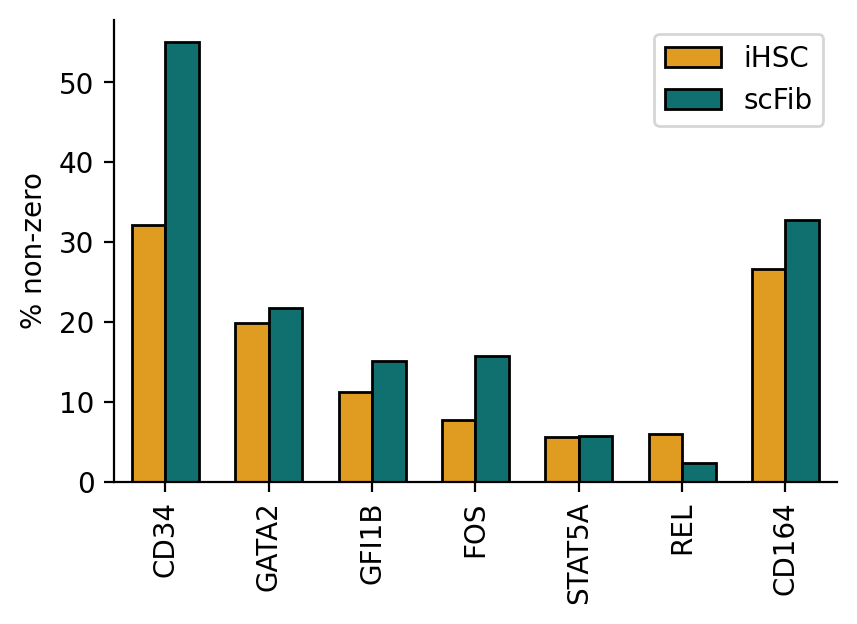

In [5]:
"""Count of cells non-zero"""

qdata = sc.get.aggregate(
    adata, 
    by='dataset', 
    func='count_nonzero', 
    axis='obs',
    layer='counts',
)

query = [
    'CD34',
    'GATA2',
    'GFI1B',
    'FOS',
    'STAT5A',
    'REL',
    'CD164',
]

counts = qdata[:, query].to_df(layer='count_nonzero')
counts = counts.divide(adata.obs['dataset'].value_counts(), axis=0) * 100
counts = counts.T
counts = counts.reset_index(drop=False, names='gene_name')
counts = pd.melt(counts, id_vars='gene_name')

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = len(query) / 1.5, 3

sns.barplot(
    data=counts,
    x='gene_name',
    y='value',
    hue='variable',
    ec='k',
    palette=["#FFA500", "#008080"],
    width=0.65,
)

plt.gca().tick_params(axis='x', rotation=90)
plt.ylabel('% non-zero')
plt.xlabel('')
sns.despine()

sns.move_legend(
    plt.gca(),
    title='',
    loc='best',
)

In [6]:
counts = qdata.to_df(layer='count_nonzero').T
counts['diff'] = counts['iHSC'] - counts['scFib']
counts = counts.sort_values(by='diff', ascending=False)
counts.head(15)

,iHSC,scFib,diff
MILR1,7125.0,306.0,6819.0
FSTL1,7472.0,714.0,6758.0
VCY,6727.0,1148.0,5579.0
AP5M1,6909.0,1554.0,5355.0
CFAP92,5256.0,44.0,5212.0
CEP170B,6395.0,1476.0,4919.0
ACOT8,5045.0,148.0,4897.0
NRIP2,4810.0,0.0,4810.0
TOMM70,7387.0,2579.0,4808.0
TREML4,5447.0,699.0,4748.0


In [7]:
n_genes = 50
database = 'ontology'
query = list(counts.head(n_genes).index)
edf = gget.enrichr(query, database=database)

pd.set_option('display.max_colwidth', 100)
edf[['path_name', 'adj_p_val', 'overlapping_genes']].head(15)


Tue Oct 22 08:58:35 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


,path_name,adj_p_val,overlapping_genes
0,regulation of toll-like receptor 9 signaling pathway (GO:0034163),0.143782,"[HMGB1, RAB7B]"
1,purine ribonucleotide catabolic process (GO:0009154),0.143782,"[NUDT4B, PDE2A]"
2,positive regulation of toll-like receptor signaling pathway (GO:0034123),0.143782,"[TREML4, HMGB1]"
3,ventricular septum development (GO:0003281),0.143782,"[CITED2, PDE2A]"
4,negative regulation of BMP signaling pathway (GO:0030514),0.143782,"[VWC2, FSTL1]"
5,positive regulation of cell cycle (GO:0045787),0.143782,"[PSRC1, CITED2]"
6,adenosine 5'-(hexahydrogen pentaphosphate) catabolic process (GO:1901911),0.143782,[NUDT4B]
7,adenosine 5'-(hexahydrogen pentaphosphate) metabolic process (GO:1901910),0.143782,[NUDT4B]
8,"negative regulation of CD4-positive, alpha-beta T cell differentiation (GO:0043371)",0.143782,[HMGB1]
9,negative regulation of cGMP-mediated signaling (GO:0010754),0.143782,[PDE2A]


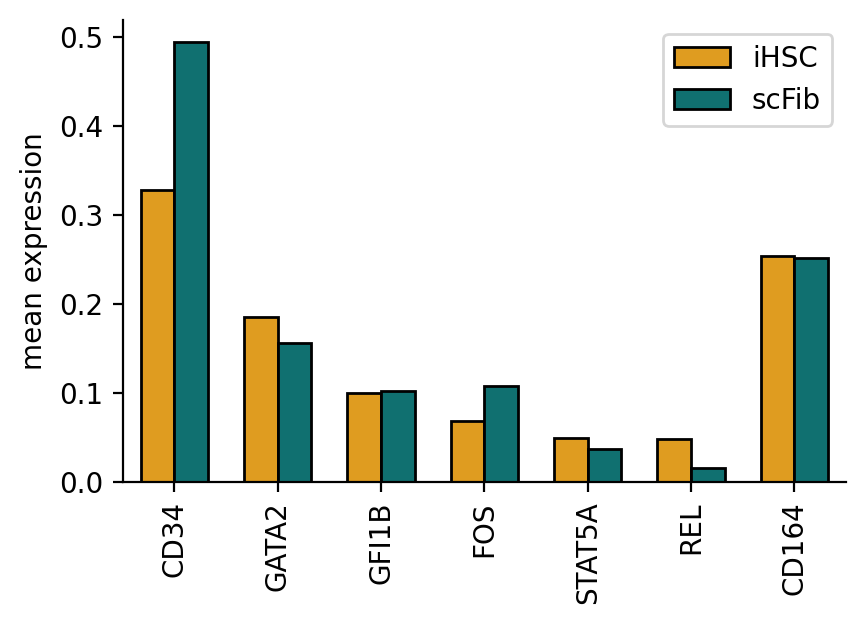

In [8]:
"""mean expression"""

qdata = sc.get.aggregate(
    adata, 
    by='dataset', 
    func='mean', 
    axis='obs',
    layer='log_norm',
)

query = [
    'CD34',
    'GATA2',
    'GFI1B',
    'FOS',
    'STAT5A',
    'REL',
    'CD164',
]

means = qdata[:, query].to_df(layer='mean').T

means = means.reset_index(drop=False, names='gene_name')
means = pd.melt(means, id_vars='gene_name')

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = len(query) / 1.5, 3

sns.barplot(
    data=means,
    x='gene_name',
    y='value',
    hue='variable',
    ec='k',
    palette=["#FFA500", "#008080"],
    width=0.65,
)

plt.gca().tick_params(axis='x', rotation=90)
plt.ylabel('mean expression')
plt.xlabel('')
sns.despine()

sns.move_legend(
    plt.gca(),
    title='',
    loc='best',
)

In [9]:
means = qdata.to_df(layer='mean').T
means['diff'] = means['iHSC'] - means['scFib']
means = means.sort_values(by='diff', ascending=False)
means.head(15)

,iHSC,scFib,diff
FSTL1,3.213182,0.109421,3.103761
MILR1,2.443349,0.032514,2.410835
TOMM70,2.775563,0.375934,2.399628
ZSWIM6,2.764163,0.524620,2.239543
AP5M1,1.802663,0.164796,1.637867
LILRA1,3.735440,2.431601,1.303839
POLD3,2.192595,0.896698,1.295897
LRWD1,1.504946,0.226744,1.278202
CEP170B,1.455199,0.186603,1.268597
DUSP5,2.980982,1.720313,1.260670


In [10]:
n_genes = 50
database = 'ontology'
query = list(means.head(n_genes).index)
edf = gget.enrichr(query, database=database)

pd.set_option('display.max_colwidth', 100)
edf[['path_name', 'adj_p_val', 'overlapping_genes']].head(15)

Tue Oct 22 08:58:36 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


,path_name,adj_p_val,overlapping_genes
0,negative regulation of toll-like receptor 4 signaling pathway (GO:0034144),0.093678,"[LILRA2, RAB7B]"
1,negative regulation of locomotion (GO:0040013),0.093678,"[CCDC125, SPOCK3]"
2,negative regulation of cellular component movement (GO:0051271),0.093678,"[CCDC125, SPOCK3]"
3,positive regulation of peptidyl-serine phosphorylation of STAT protein (GO:0033141),0.093678,"[IFNA16, IFNA2]"
4,regulation of peptidyl-serine phosphorylation of STAT protein (GO:0033139),0.093678,"[IFNA16, IFNA2]"
5,natural killer cell activation involved in immune response (GO:0002323),0.093678,"[IFNA16, IFNA2]"
6,regulation of toll-like receptor 4 signaling pathway (GO:0034143),0.093678,"[LILRA2, RAB7B]"
7,lymphocyte activation involved in immune response (GO:0002285),0.093678,"[IFNA16, IFNA2]"
8,response to dsRNA (GO:0043331),0.093678,"[IFNA16, IFNA2]"
9,T cell activation involved in immune response (GO:0002286),0.105724,"[IFNA16, IFNA2]"


# Cluster aggregations

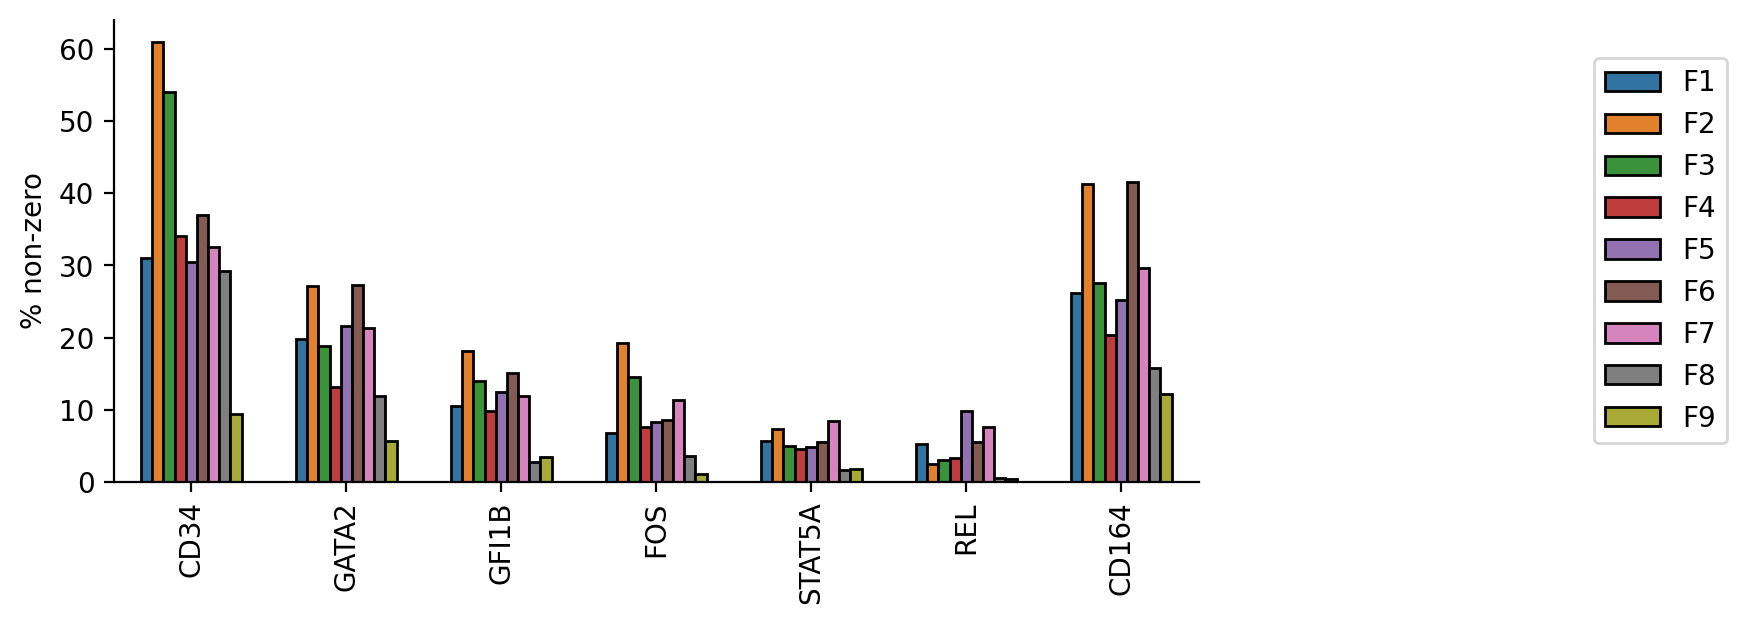

In [11]:
qdata = sc.get.aggregate(
    adata, 
    by='cluster_name', 
    func='count_nonzero', 
    axis='obs',
    layer='counts',
)

query = [
    'CD34',
    'GATA2',
    'GFI1B',
    'FOS',
    'STAT5A',
    'REL',
    'CD164',
]

counts = qdata[:, query].to_df(layer='count_nonzero')
counts = counts.divide(adata.obs['cluster_name'].value_counts(), axis=0) * 100
counts = counts.T
counts = counts.reset_index(drop=False, names='gene_name')
counts = pd.melt(counts, id_vars='gene_name')

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = len(query) / 1, 3

sns.barplot(
    data=counts,
    x='gene_name',
    y='value',
    hue='variable',
    ec='k',
    width=0.65,
)

plt.gca().tick_params(axis='x', rotation=90)
plt.ylabel('% non-zero')
plt.xlabel('')
sns.despine()

sns.move_legend(
    plt.gca(),
    title='',
    loc='center right',
    bbox_to_anchor=(1.5, 0.5)
)

In [12]:
counts = qdata.to_df(layer='count_nonzero').T
counts['HSC_like'] = counts[['F4', 'F7']].sum(axis=1)
counts['FB_like'] = counts[['F1', 'F2','F3', 'F5', 'F6']].sum(axis=1)
counts['diff'] = counts['HSC_like'] - counts['FB_like']

counts = counts.sort_values(by='diff', ascending=False)
counts.head(15)

,F1,F2,F3,F4,F5,F6,F7,F8,F9,HSC_like,FB_like,diff
SDF2L1,1.0,0.0,0.0,0.0,2.0,0.0,33.0,0.0,0.0,33.0,3.0,30.0
KAT7,2.0,6.0,51.0,88.0,3.0,0.0,0.0,3.0,1.0,88.0,62.0,26.0
ADCY4,3.0,0.0,2.0,1.0,2.0,1.0,31.0,0.0,0.0,32.0,8.0,24.0
OR2W3,0.0,0.0,2.0,23.0,1.0,0.0,3.0,0.0,0.0,26.0,3.0,23.0
KRTAP4-4,2.0,14.0,67.0,105.0,4.0,0.0,3.0,0.0,0.0,108.0,87.0,21.0
GET3,3.0,0.0,2.0,24.0,1.0,1.0,2.0,0.0,0.0,26.0,7.0,19.0
GLCCI1,4.0,0.0,3.0,16.0,2.0,1.0,11.0,0.0,0.0,27.0,10.0,17.0
TRPC3,21.0,11.0,45.0,58.0,8.0,1.0,45.0,0.0,1.0,103.0,86.0,17.0
CKB,2.0,21.0,17.0,16.0,0.0,0.0,39.0,3.0,0.0,55.0,40.0,15.0
DHRS4,6.0,0.0,1.0,8.0,4.0,1.0,18.0,0.0,0.0,26.0,12.0,14.0


In [13]:
n_genes = 25
database = 'ontology'
query = list(counts.head(n_genes).index)
edf = gget.enrichr(query, database=database)

pd.set_option('display.max_colwidth', 100)
edf[['path_name', 'adj_p_val', 'overlapping_genes']].head(15)

Tue Oct 22 08:58:38 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


,path_name,adj_p_val,overlapping_genes
0,regulation of protein localization to nucleus (GO:1900180),0.098138,"[CDK1, KAT7]"
1,mitotic nuclear membrane organization (GO:0101024),0.098138,"[NUP93, CDK1]"
2,mitotic nuclear membrane reassembly (GO:0007084),0.098138,"[NUP93, CDK1]"
3,nuclear membrane reassembly (GO:0031468),0.098138,"[NUP93, CDK1]"
4,positive regulation of protein localization to nucleus (GO:1900182),0.098138,"[CDK1, KAT7]"
5,positive regulation of cellular protein localization (GO:1903829),0.098138,"[CDK1, KAT7]"
6,meiotic mismatch repair (GO:0000710),0.098138,[MSH6]
7,regulation of hematopoietic stem cell proliferation (GO:1902033),0.098138,[KAT7]
8,aminophospholipid transport (GO:0015917),0.098138,[TMEM30B]
9,maintenance of DNA repeat elements (GO:0043570),0.098138,[MSH6]


# Marker Genes

In [36]:
"""mean expression"""

qdata = sc.get.aggregate(
    adata, 
    by='cluster_name', 
    func='mean', 
    axis='obs',
    layer='log_norm',
)

qdata

AnnData object with n_obs × n_vars = 9 × 13579
    obs: 'cluster_name'
    var: 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'hematopoietic_stem_cells_marker', 'fibroblasts_marker', 'large_intestine_fibroblast_marker', 'fat_fibroblast_marker', 'eye_fibroblast_marker', 'salivary_gland_fibroblast_marker', 'vasculature_fibroblast_marker', 'tongue_fibroblast_marker', 'thymus_fibroblast_marker', 'uterus_fibroblast_marker', 'spleen_hematopoietic_stem_cell_marker', 'heart_fibroblast_of_cardiac_tissue_marker', 'pancreas_fibroblast_marker', 'lung_alveolar_fibroblast_marker', 'lung_fibroblast_marker', 'prostate_fibroblast_marker', 'lymph_node_hematopoietic_stem_cell_marker', 'small_intestine_fibroblast_marker', 'bladder_fibroblast_marker', 'liver_fibroblast_marker', 'bone_marrow_hematopoietic_stem_cell_marker', '

result.shape=(5, 10)


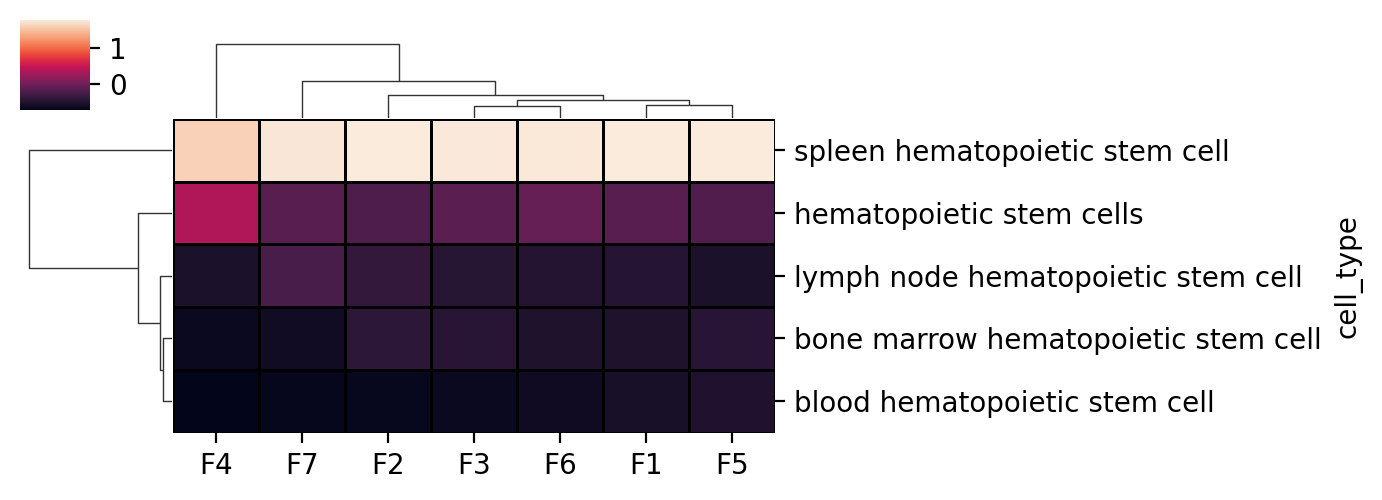

In [37]:
result = []

que = 'hemato'

for cell_type in marker_columns:
    if not que in cell_type.lower():
        continue

    cell_name = cell_type.replace("_marker", "")
    cell_name = " ".join(cell_name.split("_"))
    marker_genes = list(qdata.var[qdata.var[cell_type]].index)
    df = qdata[:, marker_genes].to_df(layer='mean').mean(axis=1)
    row = df.to_dict()
    row['cell_type'] = cell_name
    result.append(row)
    
result = pd.DataFrame(result)
print(f"{result.shape=}")
result = result.set_index('cell_type')
result = result.drop(columns=['F8', 'F9'])
result.head()

m, n = result.shape
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = n/1.75, n

g = sns.clustermap(
    result,
    figsize=(n / 1, m / 2),
    square=True,
    lw=1,
    z_score=1,
    linecolor='k',
)


plt.ylabel("")
plt.xlabel("")
plt.show()

result.shape=(19, 10)


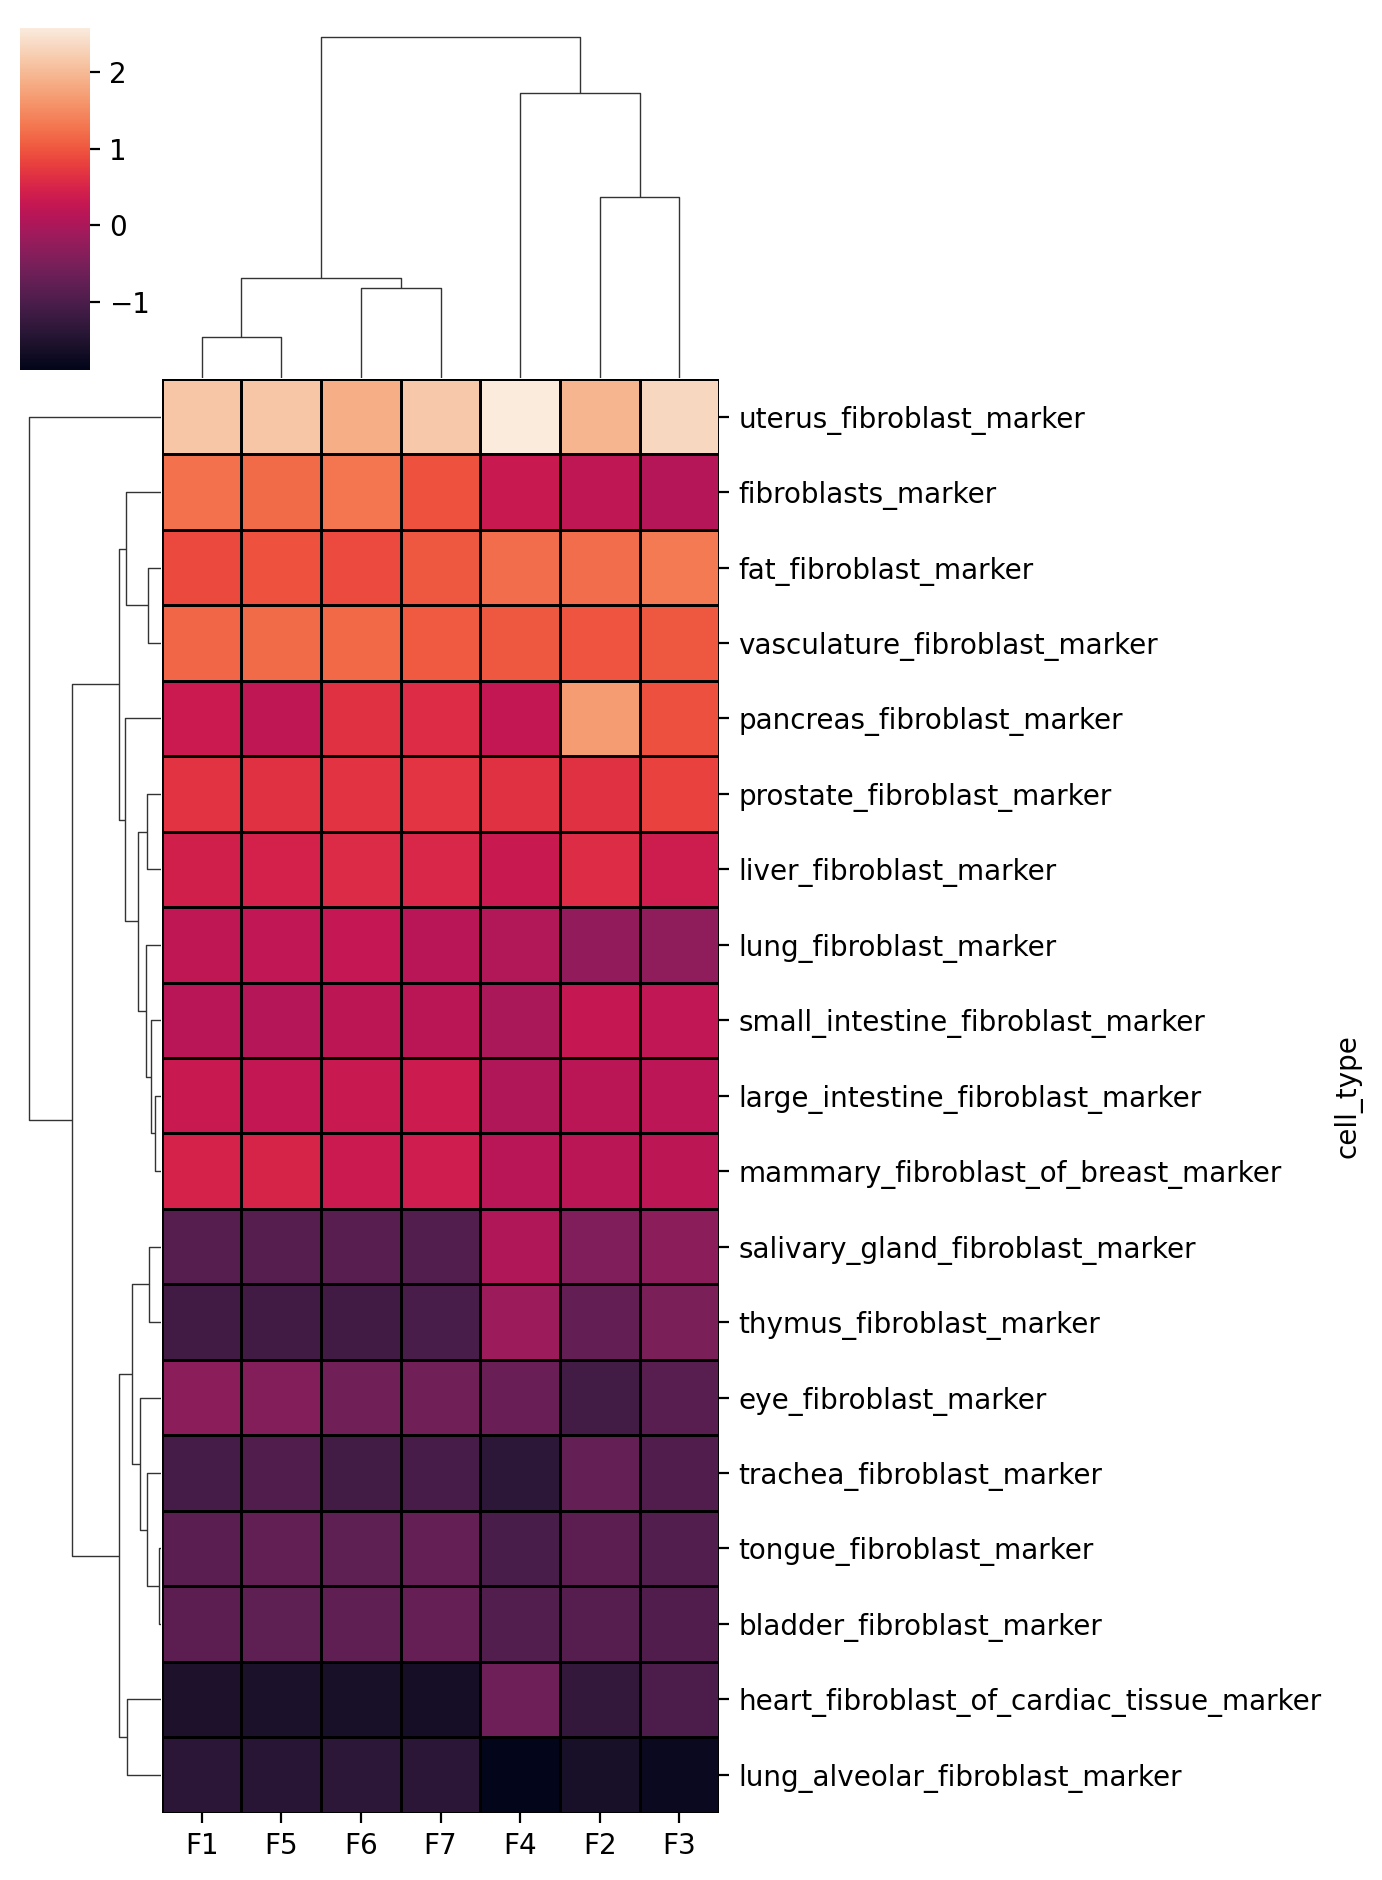

In [38]:
result = []

que = 'fibro'

for cell_type in marker_columns:
    if not que in cell_type.lower():
        continue
        
    marker_genes = list(qdata.var[qdata.var[cell_type]].index)
    df = qdata[:, marker_genes].to_df(layer='mean').mean(axis=1)
    row = df.to_dict()
    row['cell_type'] = cell_type
    result.append(row)
    
result = pd.DataFrame(result)
print(f"{result.shape=}")
result = result.set_index('cell_type')
result = result.drop(columns=['F8', 'F9'])
result.head()

m, n = result.shape
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = n/1.75, n

g = sns.clustermap(
    result,
    figsize=(n / 1, m / 2),
    square=True,
    lw=1,
    z_score=1,
    linecolor='k',
)

plt.ylabel("")
plt.xlabel("")
plt.show()